In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, concatenate, Input, Flatten
from tensorflow.keras.models import Model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split



In [ ]:
data = pd.read_csv('products_final.csv', delimiter=';')

# Lihat nama kolom yang ada di DataFrame
print(data.columns)

Index(['ID', 'Name', 'Description', 'Price Range', 'Min Order', 'Order Req',
       'Supply Ability (unit/months)', 'History View Product', 'User ID',
       'Order Click', 'Image'],
      dtype='object')


In [ ]:
# Select relevant columns for recommendation system
data = data[['ID', 'Name', 'Order Click', 'History View Product', 'Min Order']]

# Normalize data
scaler = StandardScaler()
data[['Order Click', 'History View Product', 'Min Order']] = scaler.fit_transform(data[['Order Click', 'History View Product', 'Min Order']])

# Convert data to numpy array
product_features = data[['Order Click', 'History View Product', 'Min Order']].values


<ipython-input-11-3667b98c8328>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[['Order Click', 'History View Product', 'Min Order']] = scaler.fit_transform(data[['Order Click', 'History View Product', 'Min Order']])


In [ ]:
input_dim = product_features.shape[1]
encoding_dim = 2  # Dimensi ruang laten

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='sigmoid')(encoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
encoder_model = Model(inputs=input_layer, outputs=encoder)

# Kompilasi model
autoencoder.compile(optimizer='adam', loss='mse')


In [ ]:
# Membagi data menjadi training dan testing
X_train, X_test = train_test_split(product_features, test_size=0.2, random_state=42)

# Latih model
history = autoencoder.fit(X_train, X_train, epochs=300, batch_size=16, shuffle=True, validation_data=(X_test, X_test))


Epoch 1/300
10/10 [==============================] - 1s 22ms/step - loss: 1.3766 - val_loss: 1.3271
Epoch 2/300
10/10 [==============================] - 0s 7ms/step - loss: 1.3694 - val_loss: 1.3190
Epoch 3/300
10/10 [==============================] - 0s 7ms/step - loss: 1.3628 - val_loss: 1.3103
Epoch 4/300
10/10 [==============================] - 0s 7ms/step - loss: 1.3560 - val_loss: 1.3018
Epoch 5/300
10/10 [==============================] - 0s 5ms/step - loss: 1.3492 - val_loss: 1.2935
Epoch 6/300
10/10 [==============================] - 0s 6ms/step - loss: 1.3427 - val_loss: 1.2850
Epoch 7/300
10/10 [==============================] - 0s 8ms/step - loss: 1.3360 - val_loss: 1.2769
Epoch 8/300
10/10 [==============================] - 0s 7ms/step - loss: 1.3298 - val_loss: 1.2684
Epoch 9/300
10/10 [==============================] - 0s 6ms/step - loss: 1.3233 - val_loss: 1.2603
Epoch 10/300
10/10 [==============================] - 0s 7ms/step - loss: 1.3169 - val_loss: 1.2522
Epoch 11

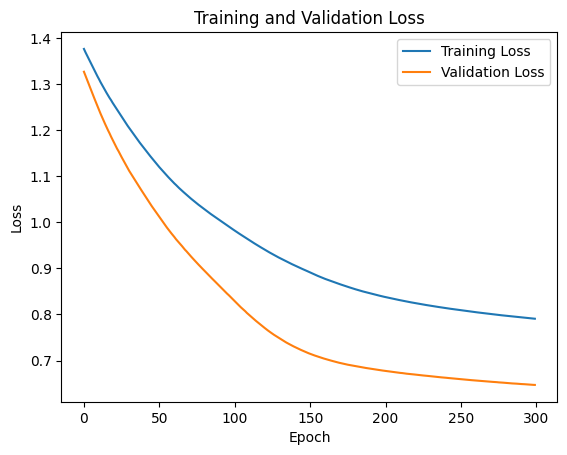

In [ ]:
# Plot training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [37]:
from sklearn.metrics.pairwise import cosine_similarity
# Get latent representation of products
product_embeddings = encoder_model.predict(product_features)

# Function to get product recommendations
def get_recommendations(product_id, embeddings, product_data, top_k=5):
    # Calculate cosine similarity with all products
    similarities = cosine_similarity([embeddings[product_id]], embeddings)[0]
    # Get indices of top_k most similar products
    similar_indices = similarities.argsort()[-top_k-1:-1][::-1]
    # Get names of recommended products
    recommended_product_names = product_data.iloc[similar_indices]['Name'].tolist()
    return recommended_product_names

# Example: Get 5 recommendations for product with ID 0
recommended_products = get_recommendations(1, product_embeddings, data, top_k=5)
print(recommended_products)



7/7 [==============================] - 0s 4ms/step
['Cacao Trinitario Grade B', 'Coffee Lini S Grade 4b', 'Cacao Criollo Grade B', 'Wood Decking', 'Coffee Robusta Grade 2']
